## Applying PINN to the PDE - 1D Version

We are interessed in solving

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot \left(\Sigma \nabla\rho(x,t) - \rho(x,t) F(\rho(x,t)) \right)

$$



Where $x=x_1$. $\Sigma = \rm{diag} (\sigma_1^2, \sigma_2^2)$. $F: \mathbb{R} \mapsto \mathbb{R}$, $F(\rho) = f(\rho).

On the domain

$$
\Omega = \{x \in [0,L]\}
$$

With boundary conditions

$$
j \cdot n = -a (\rho_{max} - \rho) \quad \forall x \in \Gamma_{in}
$$

$$
j \cdot n = b \rho \quad \forall x \in \Gamma_{out}
$$


where

$$
\Gamma_{in} = \{(x_1, x_2) \in \Omega: x_1 = 0\}
$$

$$
\Gamma_{out} = \{(x_1, x_2) \in \Omega: x_1 = L\}
$$


With $j = -\Sigma \nabla \rho + \rho F(\rho)$, in 1-D, $j = -\sigma_1 \frac{\partial \rho}{\partial x_1} + \rho f(\rho)$ and $n$ the outer normal vector, i.e. vector points toward the interior:

$$
n = -1 \quad \rm{for} \quad \Gamma_{in}
$$

$$
n = 1\quad \rm{for} \quad \Gamma_{out}
$$


In a more explicit manner, the PDE can be written as

$$
\frac{\partial \rho}{\partial t} = \sigma_1 \frac{\partial^2 \rho}{\partial x_1^2} - \frac{\partial \rho}{\partial x_1} \left(f(\rho(x,t)) + \rho(x,t) \frac{d f(\rho(x,t))}{d \rho} \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [2]:
# Correct that to import from the other file

from abc import ABC, abstractmethod

class FundamentalDiagram():
    def __init__(self, params):
        self.params = params

    def __call__(self,density):
        return self.flux(density)
    
    @abstractmethod
    def flux(self, density):
        pass

    @abstractmethod
    def __str__(self):
        pass



class Greenshield(FundamentalDiagram):
    def __init__(self, params):
        super().__init__(params)
        self.v_max = self.params[0]
        self.p_max = self.params[1]
    
    def flux(self, density):
        return self.v_max * (1 - (density/self.p_max))
    
    def d_flux(self, density):
        return - self.v_max/self.p_max + 0*density
    
    def __str__(self):
        return "Greenshield"

In [3]:
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [4]:
# input = (x1, x2, t)

In [287]:
sigma1 = 0.5**2


L = 3
T = 20

a = 0.9
b = 0.975


v_max = 2
p_max = 1 # rho_max cannot be learned Susana's paper
func = Greenshield([v_max, p_max])

In [7]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [8]:
def pde_loss(model, func, input, sigma1):
    
    # p = rho

    rho, grad = jax.vmap(jax.value_and_grad(model))(input)
    hess = jax.vmap(jax.hessian(model))(input)

    dp_dx1 = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx12 = hess[:, 0, 0]


    fp = func.flux(rho)
    df_p = func.d_flux(rho)

    rhs = sigma1*d2p_dx12 - dp_dx1 * (fp + rho*df_p)

    return jnp.mean((dp_dt - rhs)**2)

In [9]:
pde_loss(model, func, batch_input_data,  sigma1=sigma1)

Array(0.03133956, dtype=float32)

In [10]:
batch_input_data

Array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float32)

In [11]:
def j(model, func, input, sigma1):
    rho, grad = jax.vmap(jax.value_and_grad(model))(input)

    i_0 = - sigma1*grad[:, 0] + rho * func(rho)

    return i_0, rho

In [12]:
def in_loss(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0, T, steps)
    x1_flat = jnp.zeros_like(t)
    result = jnp.stack((x1_flat, t), axis=-1)
    in_ , rho = j(model, func, result, sigma1)
    in_theorical = -a * (func.p_max - rho)

    return jnp.mean((-in_ - in_theorical)**2)


In [65]:
def in_loss1(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0.2, T, steps)
    x1_flat = jnp.zeros_like(t)
    result = jnp.stack((x1_flat, t), axis=-1)
    in_ , rho = j(model, func, result, sigma1)
    in_theorical = -a * (func.p_max - rho)

    return jnp.mean((-in_ - in_theorical)**2)


In [222]:
def in_loss2(model, func, T, sigma1, a, steps=20):

    t = jnp.linspace(0, 0.5, steps)
    x1_flat = jnp.zeros_like(t)
    result = jnp.stack((x1_flat, t), axis=-1)
    in_ , rho = j(model, func, result, sigma1)
    in_theorical = -a * (func.p_max - rho)

    return jnp.mean((-in_ - in_theorical)**2)


In [223]:
in_loss(model, func, T, sigma1, a)

Array(0.00321501, dtype=float32)

In [224]:
def out_loss(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0, T, steps)
    x1_flat = jnp.full_like(t, L)
    result = jnp.stack((x1_flat, t), axis=-1)
    out_ , rho = j(model, func, result, sigma1)
    out_theorical = b * rho

    return jnp.mean((out_ - out_theorical)**2)

In [225]:
def out_loss1(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0.2, T, steps)
    x1_flat = jnp.full_like(t, L)
    result = jnp.stack((x1_flat, t), axis=-1)
    out_ , rho = j(model, func, result, sigma1)
    out_theorical = b * rho

    return jnp.mean((out_ - out_theorical)**2)

In [226]:
def out_loss2(model, func, T, sigma1, b, steps=20):

    t = jnp.linspace(0, 0.5, steps)
    x1_flat = jnp.full_like(t, L)
    result = jnp.stack((x1_flat, t), axis=-1)
    out_ , rho = j(model, func, result, sigma1)
    out_theorical = b * rho

    return jnp.mean((out_ - out_theorical)**2)

In [227]:
out_loss1(model, func, T, sigma1, b)

Array(0.00670768, dtype=float32)

In [228]:
def time_loss(model, L, steps=20):

    x1 = jnp.linspace(0, L, steps)
    t_flat = jnp.zeros_like(x1)
    result = jnp.stack((x1, t_flat), axis=-1)
    rho = jax.vmap(model)(result)

    return jnp.mean(rho**2)

In [229]:
time_loss(model, L)

Array(0.00204338, dtype=float32)

In [356]:
def loss(model, func, input, L, T, sigma1, a, b, steps=20):

    return (10*pde_loss(model, func, input,  sigma1)+ in_loss(model, func, T, sigma1, a, steps) + 
            out_loss(model, func, T, sigma1, b, steps)
            + time_loss(model, L, steps))

In [358]:
def loss1(model, func, input, L, T, sigma1, a, b, steps=20):

    return (10*pde_loss(model, func, input,  sigma1)+ in_loss1(model, func, T, sigma1, a, steps) + 
            out_loss1(model, func, T, sigma1, b, steps)
            + 0.01*time_loss(model, L, steps))

In [360]:
def loss2(model, func, input, L, T, sigma1, a, b, steps=20):

    return (10*pde_loss(model, func, input,  sigma1)+ in_loss2(model, func, T, sigma1, a, steps) + 
            out_loss2(model, func, T, sigma1, b, steps)
            + time_loss(model, L, steps))

In [361]:
loss2(model, func, batch_input_data, L, T, sigma1, a, b)

Array(0.07244704, dtype=float32)

In [362]:
def generate_latin_hypercube_samples(num_samples, x1, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [363]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-2]:
            x = jax.nn.gelu(layer(x))
            # So far, softplus seems to be the best
            # squareplus is curious
            # celu shallow (1 layer) got the steady state thing and the curious curve on the x,y plane at steady state.
            # swish got somewhat excelent results, but the PDE loss is high
        
        x = jax.nn.swish(self.layers[-2](x))
        x = self.layers[-1](x)
        return x

In [364]:
from jax import jit

class WeightedAverageNN(eqx.Module):
    nn1: MLP
    nn2: MLP
    theta1: jnp.ndarray
    theta2: jnp.ndarray

    def __init__(self, key, nn1, nn2):
        self.nn1 = nn1
        self.nn2 = nn2
        key1, key2 = jax.random.split(key)
        self.theta1 = jax.random.normal(key1, ()) + 15.0
        self.theta2 = jax.random.normal(key2, ()) + 10.0

    @jit
    def sigmoid(self, t):
        return jax.nn.sigmoid(self.theta1 * t - self.theta2)

    def __call__(self, z):
        x, t = z[0], z[1]
        output1 = self.nn1(jnp.stack([x, t], axis=-1))
        output2 = self.nn2(jnp.stack([x, t], axis=-1))
        f_t = self.sigmoid(t)
        return output1 * f_t + output2 * (1 - f_t)


In [383]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key1 = jax.random.PRNGKey(1)


output_dim = 'scalar'

model1 = MLP(model_key1, input_dim=2, hidden_dims=1024, n_layers=1, output_dim=output_dim)

In [384]:
# Optimizer definition
lr = 10e-3
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model1)

In [385]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, L, T, sigma1, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss1)(model, func, input, L, T, sigma1, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [386]:
# Training loop
num_epochs = 20000
losses = []



sample_n = 20
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model1, opt_state, loss_value = train_step(model1, opt_state, func, x, L, T, sigma1, a, b, steps=20)
    if epoch % 100 == 0:
        #x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model1)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0.2,T]) # Latin Hypercube sample
final_loss = loss1(model1, func, x, L, T, sigma1, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 91.49496459960938
Epoch 100, Loss: 0.3102550208568573
Epoch 200, Loss: 0.20814353227615356
Epoch 300, Loss: 0.17407819628715515
Epoch 400, Loss: 0.14476116001605988
Epoch 500, Loss: 0.12073808908462524
Epoch 600, Loss: 0.10152662545442581
Epoch 700, Loss: 0.08636926114559174
Epoch 800, Loss: 0.07449892908334732
Epoch 900, Loss: 0.06523431092500687
Epoch 1000, Loss: 0.05800296738743782
Epoch 1100, Loss: 1.5654247999191284
Epoch 1200, Loss: 0.25811445713043213
Epoch 1300, Loss: 0.11743437498807907
Epoch 1400, Loss: 0.06879997998476028
Epoch 1500, Loss: 0.04678075388073921
Epoch 1600, Loss: 0.03496146202087402
Epoch 1700, Loss: 0.027794864028692245
Epoch 1800, Loss: 0.02301856316626072
Epoch 1900, Loss: 0.01958760805428028
Epoch 2000, Loss: 0.016977768391370773
Epoch 2100, Loss: 1.695967197418213
Epoch 2200, Loss: 0.22732554376125336
Epoch 2300, Loss: 0.10845054686069489
Epoch 2400, Loss: 0.07120241969823837
Epoch 2500, Loss: 0.05574493855237961
Epoch 2600, Loss: 0.04748975

In [387]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key2 = jax.random.PRNGKey(5)


output_dim = 'scalar'

model2 = MLP(model_key2, input_dim=2, hidden_dims=1024, n_layers=1, output_dim=output_dim)

In [388]:
# Optimizer definition
lr = 10e-3
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model2)

In [389]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, L, T, sigma1, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss2)(model, func, input, L, T, sigma1, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [390]:
# Training loop
num_epochs = 20000
losses = []



sample_n = 20
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,0.5]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model2, opt_state, loss_value = train_step(model2, opt_state, func, x, L, T, sigma1, a, b, steps=20)
    if epoch % 100 == 0:
        #x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        #sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model1)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,0.2]) # Latin Hypercube sample
final_loss = loss2(model2, func, x, L, T, sigma1, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 1.3379758596420288
Epoch 100, Loss: 0.14317099750041962
Epoch 200, Loss: 0.05682665854692459
Epoch 300, Loss: 0.04415130242705345
Epoch 400, Loss: 0.03721077740192413
Epoch 500, Loss: 0.03282701224088669
Epoch 600, Loss: 0.030134795233607292
Epoch 700, Loss: 0.02841341309249401
Epoch 800, Loss: 0.027205828577280045
Epoch 900, Loss: 0.026273151859641075
Epoch 1000, Loss: 0.025508565828204155
Epoch 1100, Loss: 0.14799576997756958
Epoch 1200, Loss: 0.03637470304965973
Epoch 1300, Loss: 0.028339071199297905
Epoch 1400, Loss: 0.024931643158197403
Epoch 1500, Loss: 0.023552875965833664
Epoch 1600, Loss: 0.023002488538622856
Epoch 1700, Loss: 0.022765126079320908
Epoch 1800, Loss: 0.022629976272583008
Epoch 1900, Loss: 0.02252097800374031
Epoch 2000, Loss: 0.02241445891559124
Epoch 2100, Loss: 0.040077243000268936
Epoch 2200, Loss: 0.028054604306817055
Epoch 2300, Loss: 0.023248542100191116
Epoch 2400, Loss: 0.02116580680012703
Epoch 2500, Loss: 0.020304439589381218
Epoch 2600,

In [391]:
key3 = jax.random.PRNGKey(9)


model = WeightedAverageNN(key3, model1, model2)

In [392]:
# Optimizer definition
lr = 10e-3
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [393]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, func, input, L, T, sigma1, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, func, input, L, T, sigma1, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [394]:
# Training loop
num_epochs = 10000
losses = []



sample_n = 20
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample

sample_points = x.copy()

for epoch in range(num_epochs):
    
    model, opt_state, loss_value = train_step(model, opt_state, func, x, L, T, sigma1, a, b, steps=20)
    if epoch % 100 == 0:
        #x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
        sample_points = jnp.vstack((sample_points, x))
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    # if epoch % 1000 == 0:
    #     lr *= 0.4
    #     optimizer = optax.adam(learning_rate=lr)
    #     opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate

        

# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
final_loss = loss(model, func, x, L, T, sigma1, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.01542644202709198
Epoch 100, Loss: 0.010066427290439606
Epoch 200, Loss: 0.005737592000514269
Epoch 300, Loss: 0.005083219613879919
Epoch 400, Loss: 0.004913071636110544
Epoch 500, Loss: 0.004775017034262419
Epoch 600, Loss: 0.004634183831512928
Epoch 700, Loss: 0.004485194571316242
Epoch 800, Loss: 0.0043262215331196785
Epoch 900, Loss: 0.004156377632170916
Epoch 1000, Loss: 0.003975196275860071
Epoch 1100, Loss: 0.0037826166953891516
Epoch 1200, Loss: 0.0035794926807284355
Epoch 1300, Loss: 0.003368615871295333
Epoch 1400, Loss: 0.0031558526679873466
Epoch 1500, Loss: 0.0029501807875931263
Epoch 1600, Loss: 0.0027612082194536924
Epoch 1700, Loss: 0.002594552468508482
Epoch 1800, Loss: 0.0024488179478794336
Epoch 1900, Loss: 0.0023272945545613766
Epoch 2000, Loss: 0.002192623680457473
Epoch 2100, Loss: 0.002071137074381113
Epoch 2200, Loss: 0.0019532772712409496
Epoch 2300, Loss: 0.0018376403022557497
Epoch 2400, Loss: 0.0017872728640213609
Epoch 2500, Loss: 0.0016130

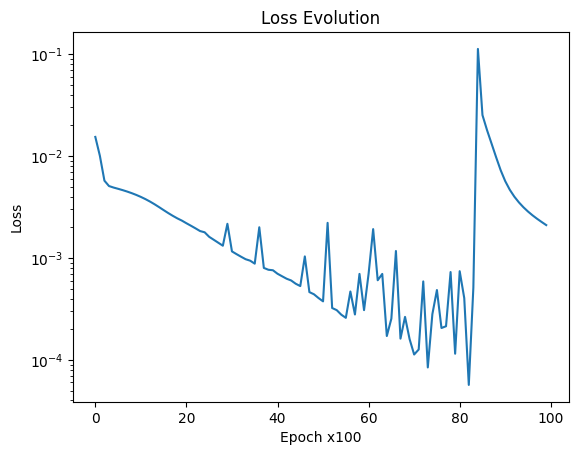

In [395]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [396]:
# batch = generate_latin_hypercube_samples(10*sample_n, [0,L], [0,T]) 

In [401]:
print(pde_loss(model, func, batch,  sigma1=sigma1))
print(in_loss(model, func, T, sigma1, a))
print(out_loss(model, func, T, sigma1,  b))
print(time_loss(model, L))

1.3540798
6.0045237e-05
0.0014277137
0.00024486976


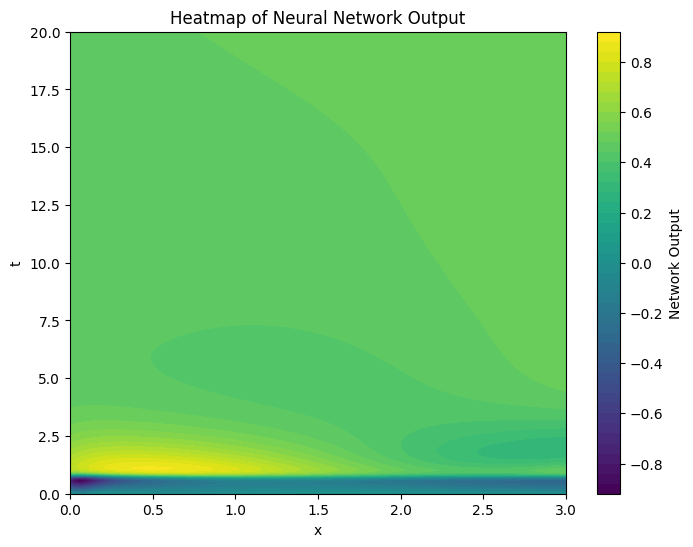

In [402]:
n_points = 200
x = jnp.linspace(0, L, n_points)
t = jnp.linspace(0, T, n_points)
X_grid, T_grid = jnp.meshgrid(x, t)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)

outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(n_points, n_points)

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=50, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

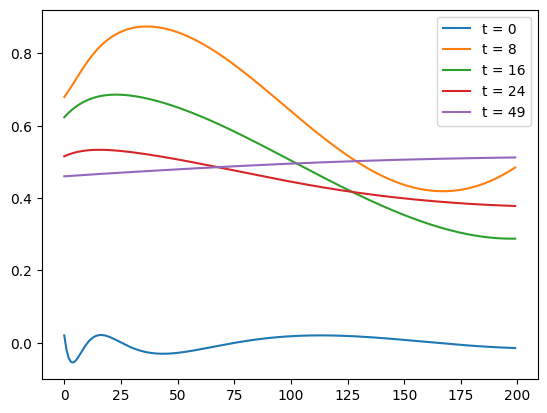

In [403]:
plt.plot(outputs[0], label='t = 0')
plt.plot(outputs[10], label='t = 8')
plt.plot(outputs[20], label='t = 16')
plt.plot(outputs[30], label='t = 24')
plt.plot(outputs[200], label='t = 49')
#plt.ylim([0.3, 0.7])
plt.legend()
plt.show()

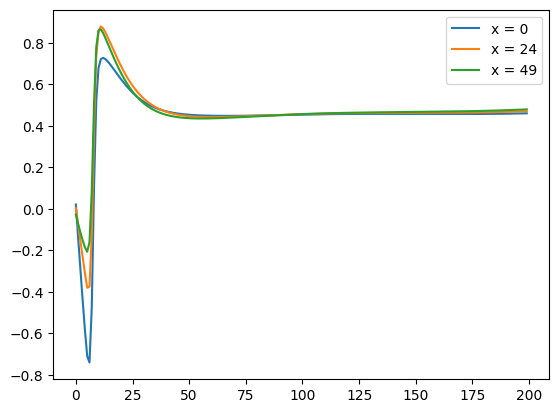

In [404]:
plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[24], label='x = 24')
plt.plot(outputs.T[49], label='x = 49')
plt.legend()
plt.show()

In [311]:
len(outputs)

200